In [55]:
from my_imports import *


데이터 불러오기 (2013~2023 훈련데이터, 2024 01~04 테스트데이터)


In [56]:
train_data = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-01')
print(f"{train_data}")
print(f"{test_data}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2013-01-02 00:00:00+00:00   16.705698   19.608213   19.821428   19.343929   
2013-01-03 00:00:00+00:00   16.494835   19.360714   19.631071   19.321428   
2013-01-04 00:00:00+00:00   16.035381   18.821428   19.236786   18.779642   
2013-01-07 00:00:00+00:00   15.941054   18.710714   18.903570   18.400000   
2013-01-08 00:00:00+00:00   15.983958   18.761070   18.996071   18.616072   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  192.868134  193.600006  195.410004  192.970001   
2023-12-26 00:00:00+00:00  192.320221  193.050003  193.889999  192.830002   
2023-12-27 00:00:00+00:00  192.419830  193.149994  193.500000  191.089996   
2023-12-28 00:00:00+00:00  192.848206  193.580002  194.660004  193.169998   

데이터 전처리 , 피처 엔지니어링


In [57]:
for data in [train_data, test_data]:
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'].squeeze()).rsi()
    #dropna() 전에 데이터 크기 확인
    print(f"Before dropna: {data.shape}")
    data.dropna(inplace=True)
    print(f"After dropna: {data.shape}")

Before dropna: (2768, 8)
After dropna: (2755, 8)
Before dropna: (83, 8)
After dropna: (70, 8)


피처와 타깃 변수 설정


In [58]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI']

X_train = train_data[features].values
y_train = (train_data['Close']).shift(-1) > train_data['Close'].astype(int)
X_train = X_train[:-1]

X_test = test_data[features].values
y_test = (test_data['Close']).shift(-1) > test_data['Close'].astype(int)
X_test = X_test[:-1]

print(X_test.shape)

(69, 7)


데이터 정규화


In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test.shape)

(69, 7)


트랜스포머 모델 정의

In [60]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 멀티헤드 어텐션
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    
    # 피드포워드 네트워크
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

모델 빌드 함수 정의

In [61]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    x = tf.keras.layers.Flatten()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

모델 생성

In [62]:
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout= 0.4,
    dropout= 0.25
)

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ input_layer_7[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 7, 4)      │          8 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 7, 4)      │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ dropout_38[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │     19,460 │ add_33[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 7, 4)      │         20 │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 7, 4)      │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ dropout_40[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │     19,460 │ add_35[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 69,516 (271.55 KB)

 Trainable params: 69,516 (271.55 KB)

 Non-trainable params: 0 (0.00 B)

모델 컴파일 및 학습

Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.6443 - loss: 0.7928 - val_accuracy: 0.3920 - val_loss: 0.8902
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7249 - loss: 0.6509 - val_accuracy: 0.4156 - val_loss: 0.8318
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7734 - loss: 0.5602 - val_accuracy: 0.3866 - val_loss: 0.7920
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7523 - loss: 0.5569 - val_accuracy: 0.4083 - val_loss: 0.8849
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7626 - loss: 0.5722 - val_accuracy: 0.5572 - val_loss: 0.6970
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7791 - loss: 0.5531 - val_accuracy: 0.5154 - val_loss: 0.7176
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7636 - loss: 0.5712 - val_accuracy: 0.5535 - val_loss: 0.6980
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7703 - loss: 0.5707 - val_accuracy: 0

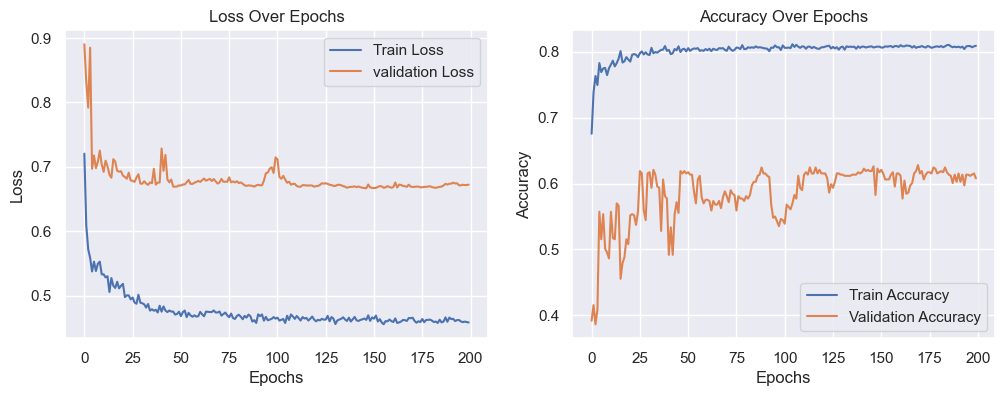

In [63]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32)

# 학습 곡선 시각화
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

훈련 데이터 성능 평가

In [67]:
# 훈련 데이터 결과
y_train_pred = model.predict(X_train)
threshold = y_train_pred.mean() #훈련 데이터 비율로 threshold 설정
y_train_pred_threshold = (y_train_pred > threshold).astype(int)
print(y_train.shape)

accuracy_train = accuracy_score(y_train, y_train_pred_threshold)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_threshold)
print(f"훈련 데이터 정확도: {accuracy_train:.2f}")
print("훈련 데이터 혼동 행렬:")
print(conf_matrix_train)
print("\n훈련 데이터 분류 리포트:")
print(classification_report(y_train, y_train_pred_threshold))

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2755, 2754]